## Segmentation Training (binary segmentation) ##
### Import packages and specify training parameters ###

In [1]:
from fastai.basics import *
from fastai.vision import *
from fastai.vision.core import *
from fastai.vision.data import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from semtorch import get_segmentation_learner

import albumentations

/home/aarlova/anaconda3/envs/pytorch_lym_clone/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
from albumentations import ShiftScaleRotate, CoarseDropout, Cutout
from albumentations import Compose


In [3]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

In [4]:
dev = 1
torch.cuda.set_device('cuda:'+str(dev))
# torch.cuda.set_device(dev)

In [23]:
numeph = 25
lr = 0.00001

#where models get saved
outdir = Path('/media/14TB/aarlova_ovarian/segmentation/training_log/')

#the dataset
foll = pd.read_csv('/media/14TB/aarlova_ovarian/20x_nonorm_dgx.csv')
foll_short = foll[0::10]
print(len(foll))
print(len(foll_short))

13145
1315


In [24]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        # Dataset v2
        
        mask[mask == 29] = 1
        mask[mask == 71] = 2
        mask[mask == 99] = 3
        mask[mask == 106] = 4
        mask[mask == 111] = 5
        mask[mask == 118] = 6
        mask[mask == 146] = 7
        mask[mask == 154] = 8
        mask[mask == 158] = 9
        mask[mask == 172] = 10
        mask[mask == 178] = 11
        mask[mask == 195] = 12
        mask[mask == 212] = 13
        mask[mask == 223] = 14
        mask[mask == 233] = 15
        mask[mask == 237] = 16
        
        # Back to PILMask
        mask = PILMask.create(mask)
        
        
        return img, mask
    
class TargetMaskConvertTransformBinary(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 1
        mask[mask == 29] = 1
        mask[mask == 71] = 1
        mask[mask == 99] = 1
        mask[mask == 106] = 1
        mask[mask == 111] = 1
        mask[mask == 118] = 1
        mask[mask == 146] = 1
        mask[mask == 154] = 1
        mask[mask == 158] = 1
        mask[mask == 172] = 1
        mask[mask == 178] = 1
        mask[mask == 195] = 1
        mask[mask == 212] = 1
        mask[mask == 223] = 1
        mask[mask == 233] = 1
        mask[mask == 237] = 1

        # Back to PILMask
        mask = PILMask.create(mask)
        
        
        return img, mask

In [25]:
# Dataset v2
class_list = ['Background','Corpus Luteum','Primary','Atretic Antral with NM','AMF-G','AMF-O','Multilayer','do not count','Primordial','Transitional Primordial','Transitional Primary','Ovulatory Antral','Dominance Antral','Multi-oocytic','AMF-OG','Secondary','Early Antral']
class_num = list(range(0,17))

name2id = dict(zip(class_list,class_num))
print(name2id)

codes = list(name2id.keys())
print(codes)
print(len(codes))

void_code = name2id['Background']

{'Background': 0, 'Corpus Luteum': 1, 'Primary': 2, 'Atretic Antral with NM': 3, 'AMF-G': 4, 'AMF-O': 5, 'Multilayer': 6, 'do not count': 7, 'Primordial': 8, 'Transitional Primordial': 9, 'Transitional Primary': 10, 'Ovulatory Antral': 11, 'Dominance Antral': 12, 'Multi-oocytic': 13, 'AMF-OG': 14, 'Secondary': 15, 'Early Antral': 16}
['Background', 'Corpus Luteum', 'Primary', 'Atretic Antral with NM', 'AMF-G', 'AMF-O', 'Multilayer', 'do not count', 'Primordial', 'Transitional Primordial', 'Transitional Primary', 'Ovulatory Antral', 'Dominance Antral', 'Multi-oocytic', 'AMF-OG', 'Secondary', 'Early Antral']
17


In [26]:
## custom accuracy metric (excludes void code aka 'Background') - not used in this example
# def acc_follicle(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code
#     a = TensorImage(target[mask])
#     return (input.argmax(dim=1)[mask]==a).float().mean()


In [27]:
segdata = DataBlock(blocks=(ImageBlock,MaskBlock(codes)),splitter=ColSplitter(),get_x=ColReader('img'),
                    get_y=ColReader('label'),item_tfms = [TargetMaskConvertTransformBinary(), SegmentationAlbumentationsTransform(Compose([ShiftScaleRotate(p=0.5), Cutout(p=0.8, num_holes=8, max_h_size=30, max_w_size=30)]))], 
                    batch_tfms=[Normalize.from_stats(*imagenet_stats), 
                    IntToFloatTensor(div_mask = 1)])

/home/aarlova/anaconda3/envs/pytorch_lym_clone/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


### Set up dataloader ###
#### ! Change to 'foll' before training on full dataset ! ####

/home/aarlova/anaconda3/envs/pytorch_lym_clone/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


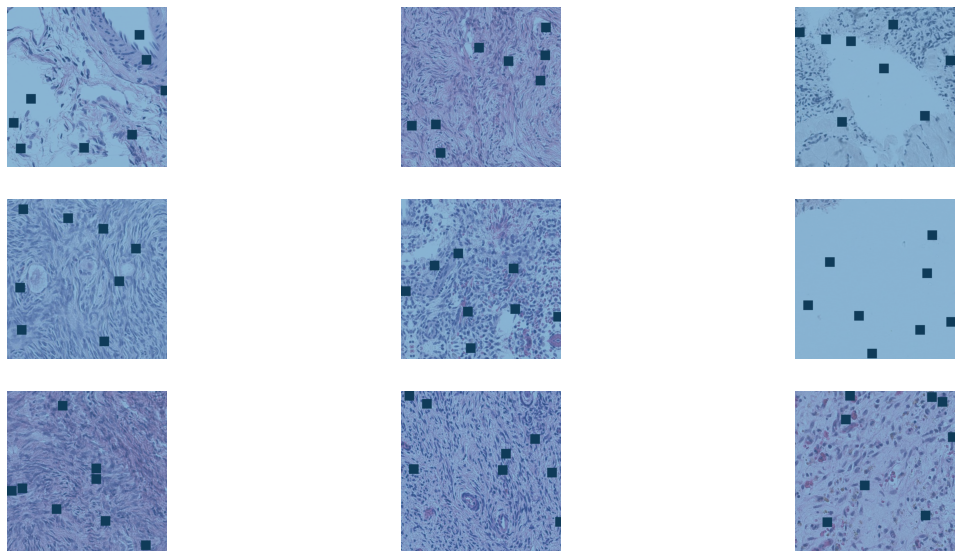

In [28]:
dls=segdata.dataloaders(foll_short,bs=16)
dls.show_batch(vmin=1,vmax=2, figsize=(20,10))

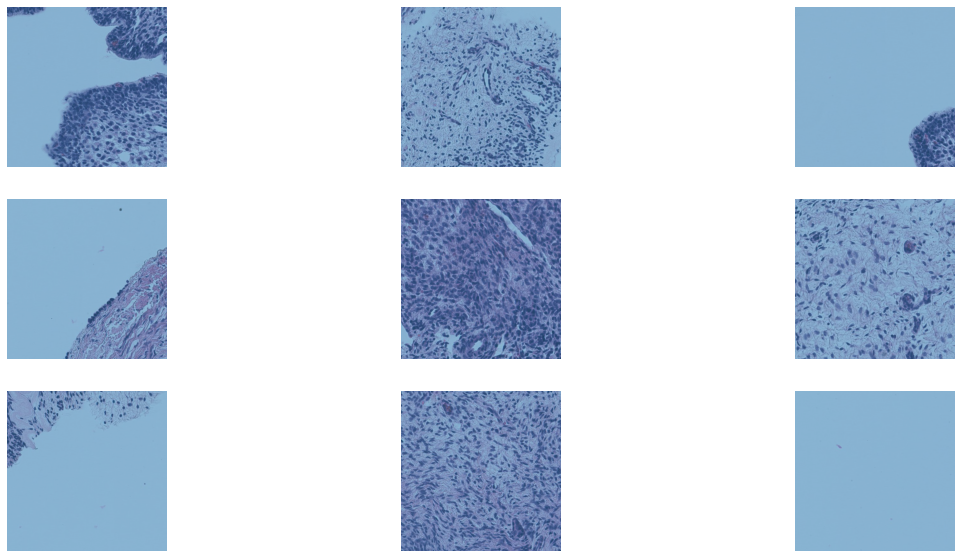

In [29]:
dls.valid.show_batch(max_n=9, vmin=1,vmax=2, figsize=(20,10))

In [30]:
dls.vocab = codes
print(dls.vocab)
print(len(dls.vocab))

['Background', 'Corpus Luteum', 'Primary', 'Atretic Antral with NM', 'AMF-G', 'AMF-O', 'Multilayer', 'do not count', 'Primordial', 'Transitional Primordial', 'Transitional Primary', 'Ovulatory Antral', 'Dominance Antral', 'Multi-oocytic', 'AMF-OG', 'Secondary', 'Early Antral']
17


### Specify Model Architecture and other parameters of Learner ###

In [31]:
architecture_name = 'hrnet'
backbone_name = 'hrnet_w30'
aug = 'AugNoStainNorm_'
magn = '_20x'
bin = '_bin'

model_name = architecture_name + '_' + backbone_name + '_' + aug + str(numeph) + magn + bin + '_' + str(lr)
print(model_name)
csv_dir = '/media/14TB/aarlova_ovarian/segmentation/train_csv/'

learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 cbs=[SaveModelCallback(fname=model_name), CSVLogger(fname=csv_dir+model_name+'.csv')],
                                 architecture_name=architecture_name, backbone_name=backbone_name,
                                 metrics=[Dice()],wd=1e-2).to_fp16()

hrnet_hrnet_w30_AugNoStainNorm_25_20x_bin_1e-05


In [18]:
# print(learn.summary())

### Run Training ###

In [32]:
learn.fit_one_cycle(numeph, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.899477,0.743169,0.023138,01:07
1,0.816125,0.748805,0.028025,01:11
2,0.598567,0.781876,0.040987,01:05
3,0.398906,0.650597,0.123587,01:11
4,0.282692,0.496305,0.277873,01:05
5,0.211622,0.331716,0.377249,01:11
6,0.169550,0.253012,0.414331,01:07
7,0.141561,0.184441,0.426201,01:10
8,0.121213,0.138226,0.434003,01:06
9,0.108424,0.117957,0.450650,01:08


/home/aarlova/anaconda3/envs/pytorch_lym_clone/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Better model found at epoch 0 with valid_loss value: 0.7431686520576477.
Better model found at epoch 3 with valid_loss value: 0.650596559047699.
Better model found at epoch 4 with valid_loss value: 0.4963052272796631.
Better model found at epoch 5 with valid_loss value: 0.3317158818244934.
Better model found at epoch 6 with valid_loss value: 0.2530120611190796.
Better model found at epoch 7 with valid_loss value: 0.1844412237405777.
Better model found at epoch 8 with valid_loss value: 0.13822633028030396.
Better model found at epoch 9 with valid_loss value: 0.11795669049024582.
Better model found at epoch 10 with valid_loss value: 0.09458145499229431.
Better model found at epoch 11 with valid_loss value: 0.08663803339004517.
Better model found at epoch 12 with valid_loss value: 0.08132609724998474.
Better model found at epoch 13 with valid_loss value: 0.08022888004779816.
Better model found at epoch 14 with valid_loss value: 0.07108395546674728.
Better model found at epoch 16 with vali

### Optional - See Results ###

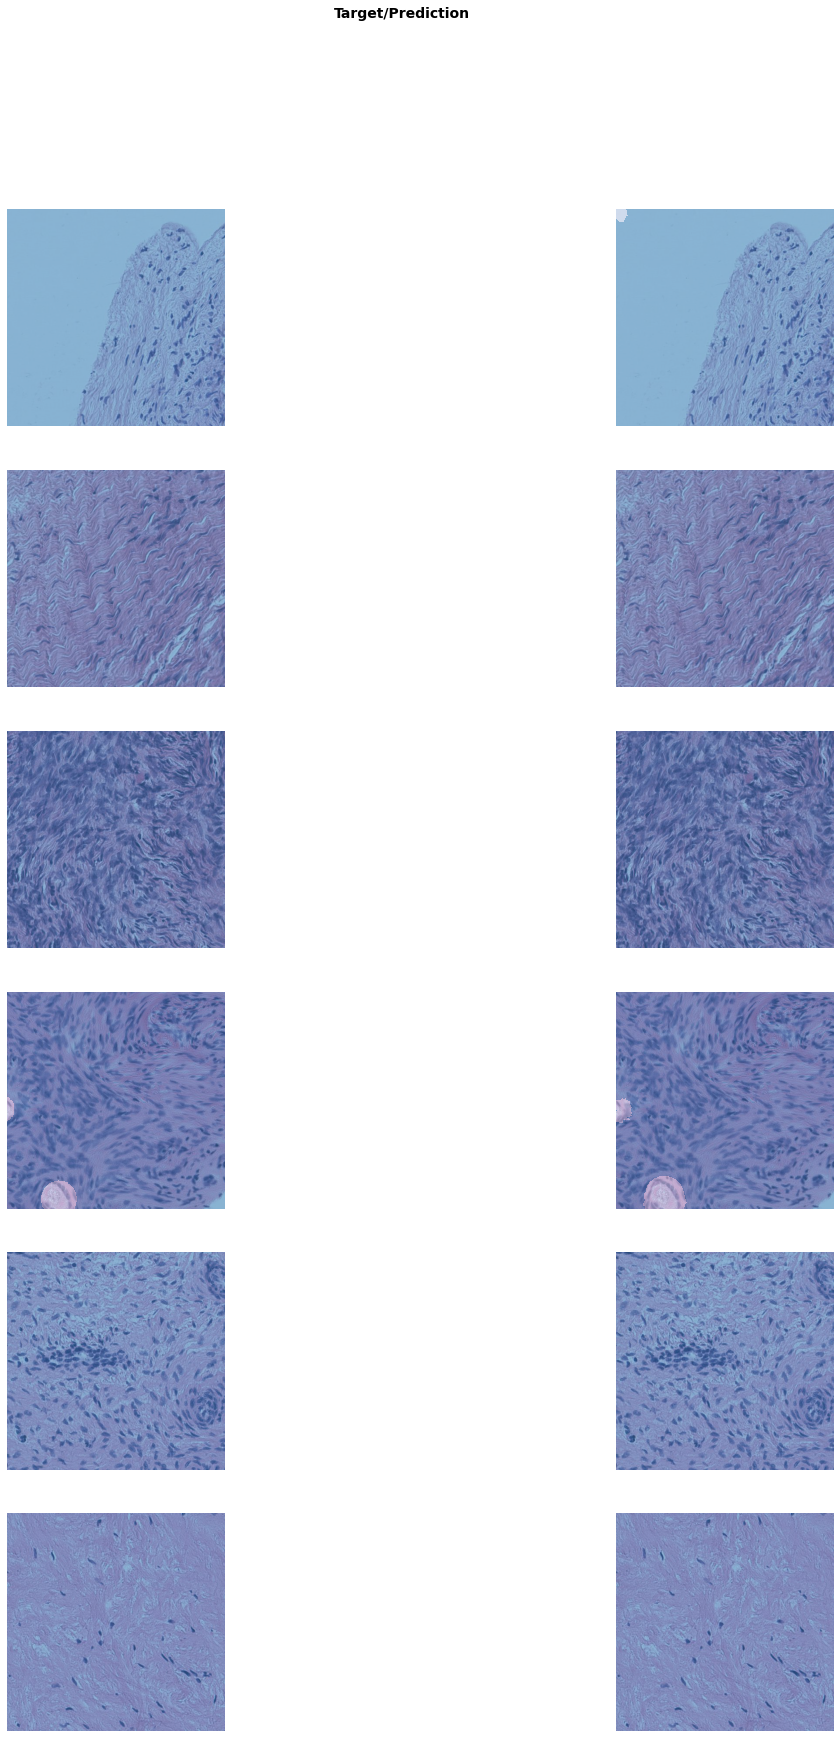

In [35]:
learn.show_results(max_n=6, figsize=(20,28))